In [1]:
## Homework 5 Solution Template
### CSCI 4270 / 6270
### Due: April 8, 2024

In [41]:
import numpy as np
import json
from PIL import Image
from os.path import join

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import models
import torchvision.transforms as transforms

In [42]:
"""
Implement and test the utilities in support of evaluating the results
from the region-by-region decisions and turning them into detections.

All rectangles are four component lists (or tuples) giving the upper
left and lower right cornders of an axis-aligned rectangle.  For example, 
[2, 9, 12, 18] has upper left corner (2,9) and lower right (12, 18)

The region predictions for an image for an image are stored in a list
of dictionaries, each giving the class, the activation and the
bounding rectangle.  For example,

{
    "class": 2,
    "a":  0.67,
    "rectangle": (18, 14, 50, 75)
}

if the class is 0 this means there is no detection and the rectangle
should be ignored.  The region predictions must be turned into the
detection results by filtering those with class 0 and through non
maximum supression.  The resulting regions should be considered the
"detections" for the image.

After this, detections should be compared to the ground truth 

The ground truth regions for an image are stored as a list of dictionaries. 
Each dictionary contains the region's class and bounding rectangle.
Here is an example dictionary:

{
    "class":  3,
    "rectangle": (15, 20, 56, 65)
}

Class 0 will not appear in the ground truth.  
"""

def area(rect):
    h = rect[3] - rect[1]
    w = rect[2] - rect[0]
    return h * w


def iou(rect1, rect2):
    """
    Input: two rectangles
    Output: IOU value, which should be 0 if the rectangles do not overlap.
    """ 
    x0, y0, x1, y1 = rect1
    u0, v0, u1, v1 = rect2
    ir = (max(x0, u0), max(y0, v0), min(x1, u1), min(y1, v1))
    if ir[0] >= ir[2] or ir[1] >= ir[3]:
        return 0
    else:
        return area(ir) / (area(rect1) + area(rect2) - area(ir))


def predictions_to_detections(predictions, iou_threshold=0.5):
    """
    Input: List of region predictions

    Output: List of region predictions that are considered to be
    detection results. These are ordered by activation with all class
    0 predictions eliminated, and the non-maximum suppression
    applied.
    """
    #filters class labels of 0 and sorts in descending order of activation
    nonzero_predict = [region for region in predictions if region['class'] != 0]
    nonzero_predict.sort(key=lambda x:x['a'], reverse=True)
    
    #non-max suppression (keep track of suppressed but don't remove bc suppressed can suppress others)
    keep = []
    suppressed = []
                
    for i in nonzero_predict:
        #if a suppressed region, don't keep
        if i not in suppressed:
            keep.append(i)
        for j in nonzero_predict[1:]:
            if i['class'] == j['class']:
                iou_val = iou(i['rectangle'], j['rectangle'])
                if iou_val > iou_threshold:
                    suppressed.append(j)
        
    return keep

def evaluate(detections, gt_detections, iou_threshold=0.5):
    """
    Input:
    1. The detections returned by the predictions_to_detections function
    2. The list of ground truth regions, and
    3. The IOU threshold

    The calculation must compare each detection region to the ground
    truth detection regions to determine which are correct and which
    are incorrect.  Finally, it must compute the average precision for
    up to n detections.

    Returns:
    list of correct detections,
    list of incorrect detections,
    list of ground truth regions that are missed,
    AP@n value.
    """
    #output values
    correct = []
    incorrect = []
    missed = gt_detections.copy()
    #binary vector for ap calculation
    b = []
    for pred in detections:
        same = []
        best_iou = 0
        g = missed[0]
        #finds all the gt with same label
        for gt in missed:
            if pred['class'] == gt['class']:
                same.append(gt)
        #prefiltering, if there are no gt with same label, then it is incorrect prediction      
        if len(same) == 0:
            b.append(0)
            incorrect.append(pred)
            continue
        
        #calculates iou values and finds g (gt with best iou)
        for gt in same:
            iou_val = iou(pred['rectangle'], gt['rectangle'])
            if iou_val > best_iou:
                best_iou = iou_val
                g = gt
        
        #if g is less than threshold, incorrect prediction
        if iou(pred['rectangle'], g['rectangle']) < iou_threshold:
            b.append(0)
            incorrect.append(pred)
            continue
        
        #otherwise it is a correct prediction and remove g
        b.append(1)
        correct.append(pred)
        missed.remove(g)
    
    #precision and recall pair calc
    b_np = np.array(b)
    p = np.cumsum(b_np)/np.arange(1,len(b_np)+1)
    r = np.cumsum(b_np)/len(gt_detections)
    pairs = zip(p, r)
    
    #discussed with Charlie Chen
    #calculating all p s.t r >= j/10 for each step in recall
    steps = [[],[],[],[],[],[],[],[],[],[],[]]
    for p, r in pairs:
        for j in range(11):
            if r >= j/10: steps[j].append(p) 
            else: steps[j].append(0)
    
    #calculates the max p for each step
    phat = [] 
    for step in steps:
        phat.append(max(step))
    
    #avg precision
    ap = sum(phat)/11
    return correct, incorrect, missed, ap

In [43]:
def test_iou():
    """
    Use this function for you own testing of your IOU function
    """
    # should be .370
    rect1 = (0, 5, 11, 15)
    rect2 = (2, 9, 12, 18)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0
    rect1 = (2, -3, 11, 4)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0.2
    rect1 = (3, 12, 9, 15)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

test_iou()

iou for (0, 5, 11, 15) (2, 9, 12, 18) is 0.37
iou for (2, -3, 11, 4) (2, 9, 12, 18) is 0.00
iou for (3, 12, 9, 15) (2, 9, 12, 18) is 0.20


In [44]:
def test_evaluation_code(in_json_file):
    with open(in_json_file, "r") as in_fp:
        data = json.load(in_fp)
    
    region_predictions = data["region_predictions"]
    gt_detections = data["gt_detections"]

    detections = predictions_to_detections(region_predictions)
    print(f"DETECTIONS: count = {len(detections)}")
    if len(detections) >= 2:
        print(f"DETECTIONS: first activation {detections[0]['a']:.2f}" )
        print(f"DETECTIONS: last activation {detections[-1]['a']:.2f}")
    elif len(detections) == 1:
        print(f"DETECTIONS: only activation {detections[0]['a']:.2f}")
    else:
        print(f"DETECTIONS: no activations")

    correct, incorrect, missed, ap = evaluate(detections, gt_detections)

    print(f"AP: num correct {len(correct)}")
    if len(correct) > 0:
        print(f"AP: first correct activation {correct[0]['a']:.2f}")

    print(f"AP: num incorrect {len(incorrect)}")
    if len(incorrect) > 0:
        print(f"AP: first incorrect activation {incorrect[0]['a']:.2f}")

    print(f"AP: num ground truth missed {len(missed)}")
    print(f"AP: final AP value {ap:1.3f}")


In [45]:
test_evaluation_code('eval_test1.json')

DETECTIONS: count = 2
DETECTIONS: first activation 0.90
DETECTIONS: last activation 0.70
AP: num correct 1
AP: first correct activation 0.90
AP: num incorrect 1
AP: first incorrect activation 0.70
AP: num ground truth missed 2
AP: final AP value 0.364


In [46]:
test_evaluation_code('eval_test2.json')

DETECTIONS: count = 5
DETECTIONS: first activation 0.94
DETECTIONS: last activation 0.55
AP: num correct 4
AP: first correct activation 0.90
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.655


In [47]:
test_evaluation_code('eval_test3.json')

DETECTIONS: count = 1
DETECTIONS: only activation 0.94
AP: num correct 0
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.000


In [48]:
test_evaluation_code('eval_test4.json')

DETECTIONS: count = 11
DETECTIONS: first activation 0.89
DETECTIONS: last activation 0.65
AP: num correct 10
AP: first correct activation 0.89
AP: num incorrect 1
AP: first incorrect activation 0.88
AP: num ground truth missed 1
AP: final AP value 0.835


In [49]:
'''
Skeleton model class. You will have to implement the classification and regression layers, along with the forward definition.
'''

class RCNN(nn.Module):
    def __init__(self, num_classes):
        super(RCNN, self).__init__()
        
        # Pretrained backbone. If you are on the cci machine then this will not be able to automatically download
        #  the pretrained weights. You will have to download them locally then copy them over.
        #  During the local download it should tell you where torch is downloading the weights to, then copy them to 
        #  ~/.cache/torch/checkpoints/ on the supercomputer.
        resnet = models.resnet18(pretrained=True)

        # Remove the last fc layer of the pretrained network.
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # Freeze backbone weights. 
        for param in self.backbone.parameters():
            param.requires_grad = False

        # TODO: Implement the fully connected layers for classification and regression.
        self.num_classes = num_classes

        self.classification_layer = nn.Linear(512, num_classes+1)
        
        self.regression_layer = nn.Linear(512, 4*num_classes)
        
    def forward(self, x):
        # TODO: Implement forward. Should return a (batch_size x num_classes) tensor for classification
        #           and a (batch_size x num_classes x 4) tensor for the bounding box regression. 
        ...
        features = self.backbone(x)
        features = torch.flatten(features, 1)
        classification_output = self.classification_layer(features)
        regression_output = self.regression_layer(features)
        
        return classification_output, regression_output

In [50]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


# Dictionaries mapping class labels to names.
LABELS_TO_NAMES = {0: 'nothing',
                   1: 'bicycle',
                   2: 'car',
                   3: 'motorbike',
                   4: 'person',}


LABELS_TO_NAMES_LARGE = {0: 'nothing',
                         1: 'aeroplane',
                         2: 'bicycle',
                         3: 'bird',
                         4: 'boat',
                         5: 'bottle',
                         6: 'bus',
                         7: 'car',
                         8: 'cat',
                         9: 'chair',
                         10: 'cow',
                         11: 'diningtable',
                         12: 'dog',
                         13: 'horse',
                         14: 'motorbike',
                         15: 'person',
                         16: 'pottedplant',
                         17: 'sheep',
                         18: 'sofa',
                         19: 'train',
                         20: 'tvmonitor'}


class HW5Dataset(Dataset):
    '''
    Dataset for Train and Validation.
    Input:
        data_root - path to either the train or valid image directories
        json_file - path to either train.json or valid.json
    Output:
        candidate_region - 3 x M x M tensor
        ground_truth_bbox - 1 x 4 tensor
        ground_truth_class
    '''
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root
        self.candidate_region_size = candidate_region_size

        self.images = []
        self.candidate_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_classes = torch.empty(0, dtype=int)
        for key, values in data_dict.items():
            for val in values:
                self.images.append(key)
                self.candidate_bboxes = torch.cat((self.candidate_bboxes, torch.tensor(val['bbox']).unsqueeze(0)))
                self.ground_truth_bboxes = torch.cat((self.ground_truth_bboxes, torch.tensor(val['gt_bbox']).unsqueeze(0)))
                self.ground_truth_classes = torch.cat((self.ground_truth_classes, torch.tensor(val['class']).unsqueeze(0)))

        # Transform to convert to tensor, resize, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        
        image = Image.open(image_path)

        # Crop the image to the candidate region.
        candidate_bbox = self.candidate_bboxes[idx, :]
        candidate_region = image.crop((candidate_bbox[0].item(), candidate_bbox[1].item(), candidate_bbox[2].item(), candidate_bbox[3].item()))
        
        width, height = candidate_region.size
        x_scale = self.candidate_region_size / width
        y_scale = self.candidate_region_size / height

        # Transform to resize, convert to tensor, and normalize.
        candidate_region = self.transform(candidate_region)
        
        # Resize ground truth bounding box.
        gt_bbox = self.ground_truth_bboxes[idx, :]
        resized_gt_x0 = (gt_bbox[0] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y0 = (gt_bbox[1] - candidate_bbox[1]) * y_scale / self.candidate_region_size
        resized_gt_x1 = (gt_bbox[2] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y1 = (gt_bbox[3] - candidate_bbox[1]) * y_scale / self.candidate_region_size
        
        resized_gt_bbox = torch.tensor([resized_gt_x0, resized_gt_y0, resized_gt_x1, resized_gt_y1])
        
        return candidate_region, resized_gt_bbox, self.ground_truth_classes[idx]


class HW5DatasetTest(Dataset):
    """
    Dataset for Test.
    Input:
        data_root - path to the test image directory
        json_file - path to test.json
    Returns:
        image - numpy array A x B x 3 (RGB)
        candidate_regions - NUM_CANDIDATE_REGIONS x 3 x M x M tensor
        candidate_bboxes - all candidate bounding boxes for an image 
        ground_truth_bboxes - all ground truth bounding boxes for an image
        ground_truth_classes - all ground truth classes for an image
    """
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root

        self.images = []
        self.candidate_bboxes = []
        self.ground_truth_bboxes = []
        self.ground_truth_classes = []
        for key, values in data_dict.items():
            self.images.append(key)
            bboxes = torch.empty((len(values['candidate_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['candidate_bboxes']):
                bboxes[i, :] = torch.tensor(bbox)
            self.candidate_bboxes.append(bboxes)

            labels = torch.empty((len(values['gt_bboxes'])), dtype=int)
            bboxes = torch.empty((len(values['gt_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['gt_bboxes']):
                bboxes[i, :] = torch.tensor(bbox['bbox'])
                labels[i] = bbox['class']
            self.ground_truth_bboxes.append(bboxes)
            self.ground_truth_classes.append(labels)

        self.candidate_region_size = candidate_region_size

        # Transform to resize, convert to tensor, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        image = Image.open(image_path)

        # Apply transform to resize and normalize the candidate images.
        idx_candidate_bboxes = self.candidate_bboxes[idx]
        candidate_regions = torch.empty((len(idx_candidate_bboxes), 3, self.candidate_region_size, self.candidate_region_size))
        for i, bbox in enumerate(idx_candidate_bboxes):
            candidate_region = image.crop((bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()))
            candidate_region = self.transform(candidate_region)
            candidate_regions[i] = candidate_region

        return np.array(image), candidate_regions, self.candidate_bboxes[idx], self.ground_truth_bboxes[idx], self.ground_truth_classes[idx]


In [51]:
# Form training dataset
train_dataset = HW5Dataset("hw5_data_2024/train", "hw5_data_2024/train.json")
valid_dataset = HW5Dataset("hw5_data_2024/valid", "hw5_data_2024/valid.json")
test_dataset = HW5DatasetTest("hw5_data_2024/test", "hw5_data_2024/test.json")

The validation dataset has 5714 regions
After the shuffle the 3859th region has class index 0
Image shape is (224, 224, 3)


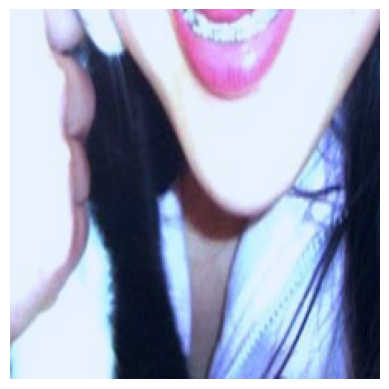

In [52]:
import random
import matplotlib.pyplot as plt

# Find and output the number of regions
n = len(valid_dataset)
print(f'The validation dataset has {n} regions')

# Randomly shuffle the region indices
indices = list(range(n))
random.shuffle(indices)

# Get the region and the class id of the random region after the shuffle.
region, gt_bbox, gt_class = valid_dataset[indices[0]]
print(f'After the shuffle the {indices[0]}th region has class index {gt_class}')

# Convert the region from an array back to a numpy 3d array
region_np = region.numpy().transpose((1, 2, 0))
print(f'Image shape is {region_np.shape}')

# Before displaying the region rescale the intensities to be between 0 and 1
region_min = region_np.min()
region_max = region_np.max()
region_np = (region_np - region_min) / (region_max - region_min)

#Display the image
plt.imshow(region_np)
plt.axis('off')
plt.show()

In [53]:
from torch.utils.data import DataLoader
#creating dataloaders for train,valid,test
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print()
#ensuring dimensions and output types (region tensor, gt bbox, class label)
print("minibatches of 4-dimensional tensors of size Bx3x224x224")
for X,y,z in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {z.dtype}")
    print(f"Shape of z: {z.shape} {z.dtype}")
    break
    
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print()

#creating NN model and ensuring final layer outputs match what we want
num_classes = len(LABELS_TO_NAMES) - 1
model = RCNN(num_classes).to(device)
print(model)
for p in model.parameters():
    print(p.size())
    
print()
mb = torch.rand(batch_size, 3, 244, 244).to(device)
c, r = model.forward(mb)
# c = [batch_size, num_classes], r = [batch_size, 4*(num_classes-1)] (exclude zero class)
print(c.size())
print(r.size())


minibatches of 4-dimensional tensors of size Bx3x224x224
Shape of X [N, C, H, W]: torch.Size([32, 3, 224, 224])
Shape of y: torch.Size([32, 4]) torch.int64
Shape of z: torch.Size([32]) torch.int64
Using cuda device

RCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [58]:
def train(dataloader, model, class_loss_fn, bbox_loss_fn, optimizer, C):
    size = len(dataloader.dataset)
    model.train()
    training_loss = 0.0
    for batch, (X, y, z) in enumerate(dataloader):
        print(batch)
        #region input, ground truth bbox, ground truth label
        X, y, z = X.to(device), y.to(device), z.to(device)
        #print(y)
        # Compute prediction error
        pred_class, pred_bbox = model(X)
        class_loss = class_loss_fn(pred_class, z)
        print("Predicted Class (32, 5)")
        #print(pred_class)
        print("GT (32, 5)")
        print(z)
        print(z[batch])
        #print("Predicted Bounding Boxes (32, 4C)")
        #print(pred_bbox)
        #only compute bbox error/loss, and backpropagate if predicted label == gt label
        if z[batch] != 0: 
            pred_bbox_correct = pred_bbox[:,C*(z[batch]-1):C*z[batch]]
            #print(pred_bbox_correct)
            bbox_loss = bbox_loss_fn(pred_bbox_correct, y)
            print(bbox_loss)
            #backpropagation
            bbox_loss.backward()
            training_loss += bbox_loss.item()
    
        # Backpropagation
        optimizer.zero_grad()
        class_loss.backward()
        optimizer.step()
        
        training_loss += class_loss.item()
    training_loss /= len(dataloader)
    return training_loss

def validate(dataloader, model, class_loss_fn, bbox_loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    valid_loss, correct = 0, 0
    #so that we do not compute gradients, only model performance
    with torch.no_grad():
        for X, y, z in dataloader:
            #region input, ground truth bbox, ground truth label
            X, y, z = X.to(device), y.to(device), z.to(device)
            pred_class, pred_bbox = model(X)
            
            #loss calc
            if z.item() != 0:
                pred_bbox_correct = pred_bbox[:,4*C:4*(C+1)]
                valid_loss += bbox_loss_fn(pred_bbox_correct, y).item()
            valid_loss += class_loss_fn(pred_class, z).item()
            
            #accuracy check
            #if gt label is not 0 and iou of gt bbox and predicted bbox is > 0.5
            if z != 0:
                iou_val = iou(y, pred_bbox)     
                if iou_val > 0.5:
                    #decision is correct if highest activation value corresponds to gt label
                    correct += (pred_class.argmax(1) == z).type(torch.float).sum().item()
            #if gt label is 0, then just check if highest activation value corresponds to gt label
            else:
                correct += (pred_class.argmax(1) == z).type(torch.float).sum().item()
                
    valid_loss /= num_batches
    correct /= size
    return correct, valid_loss

In [59]:
#reference/source: https://saturncloud.io/blog/custom-loss-function-in-pytorch-a-comprehensive-guide/
class bbox_loss(nn.Module):
    def __init__(self):
        super(bbox_loss, self).__init__()
        
    def forward(self, inputs, targets):
        loss = (inputs-targets)**2
        loss = torch.sum(loss)
        return loss

#loss func
class_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = bbox_loss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
epochs = 5
best_accuracy = 0
#for the plot
train_losses = []
valid_losses = []
#best_model = 'best_model.pth'
for t in range(epochs):
    training_loss = train(train_dataloader, model, class_loss_fn, bbox_loss_fn, optimizer, num_classes)
    validation_accuracy, validation_loss = validate(valid_dataloader, model, class_loss_fn, bbox_loss_fn)
    train_losses.append(training_loss)
    valid_losses.append(validation_loss)
    if (validation_accuracy > best_accuracy):
        best_accuracy = validation_accuracy
        #save the model 
        #torch.save(model, best_model)
        print("Epoch:", t)
        print("Training Loss:", training_loss)
        print("Accuracy:", best_accuracy)
        print()
print("Done!")

0
Predicted Class (32, 5)
GT (32, 5)
tensor([4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0,
        0, 0, 0, 0, 2, 2, 2, 2], device='cuda:0')
tensor(4, device='cuda:0')
tensor(130.2381, device='cuda:0', grad_fn=<SumBackward0>)
1
Predicted Class (32, 5)
GT (32, 5)
tensor([2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 0, 0,
        0, 0, 0, 0, 4, 4, 4, 4], device='cuda:0')
tensor(2, device='cuda:0')
tensor(165.1884, device='cuda:0', grad_fn=<SumBackward0>)
2
Predicted Class (32, 5)
GT (32, 5)
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0,
        0, 0, 0, 2, 2, 2, 2, 0], device='cuda:0')
tensor(4, device='cuda:0')
tensor(148.7877, device='cuda:0', grad_fn=<SumBackward0>)
3
Predicted Class (32, 5)
GT (32, 5)
tensor([0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
        3, 3, 2, 2, 2, 2, 4, 4], device='cuda:0')
tensor(0, device='cuda:0')
4
Predicted Class (32, 5)
GT (32, 5)
tensor([4, 4,

IndexError: index 32 is out of bounds for dimension 0 with size 32

In [ ]:
'''Training and Validation Output'''
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()